In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPClassifier
from logloss import *

In [2]:
seasons = range(2001, 2016, 1)
df = None
for season in seasons:
    try:
        temp_df = pd.read_csv('data/prepared/{}_NBAseason.csv'.format(season))
        if df is None:
            df = temp_df
        else:
            df = df.append(temp_df, ignore_index=True)
    except FileNotFoundError:
        print('ERROR: data/prepared/{}_NBAseason.csv not found'.format(season))

ERROR: data/prepared/2008_NBAseason.csv not found
ERROR: data/prepared/2009_NBAseason.csv not found
ERROR: data/prepared/2010_NBAseason.csv not found


In [3]:
msk = np.random.rand(len(df)) < 0.6
train = df[msk]
test_cval = df[~msk]
msk = np.random.rand(len(test_cval)) < 0.5
cval = test_cval[msk]
test = test_cval[~msk]

In [4]:
print('Train: ', len(train), '\n'
      'X Val: ', len(cval), '\n'
      'Test: ', len(test))

Train:  9151 
X Val:  3095 
Test:  3093


In [5]:
#isolating features from dataframe

features = ['Day_Num', 'Home_DaysPast', 'Visitor_DaysPast',
            'Home_TotalWins','Home_TotalLosses', 'Home_HomeWins', 'Home_HomeLosses', 'Home_Streak', 
            'Home_AvgSpread', 'Home_AvgPts', 'Home_GamesPlayed',  
            'Visitor_TotalWins', 'Visitor_TotalLosses', 'Visitor_VisitorWins', 'Visitor_VisitorLosses', 'Visitor_Streak', 
            'Visitor_AvgSpread', 'Visitor_AvgPts', 'Visitor_GamesPlayed']

train_features = train[features]
cval_features = cval[features]
test_features = test[features]


train_labels = train['Winner']
cval_labels = cval['Winner']
test_labels = test['Winner']

#### Computing the Ideal NN size through minimization of Logloss

In [6]:
(logloss, num_layers, num_perceptrons, logloss_list, layers_list, perceptrons_list) =\
    minimize_logloss(train_features, train_labels, cval_features, cval_labels.tolist())

<IPython.core.display.Javascript object>


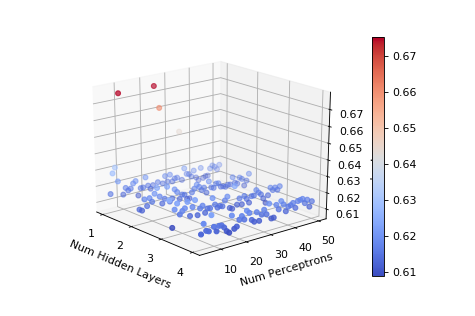

Minimum Logloss Found: 0.6177739340473591
Hidden Layers @ Min: 3
Perceptrons @ Min: 44


In [22]:
%matplotlib notebook

X = np.asarray(layers_list)
Y = np.asarray(perceptrons_list)
Z = np.asarray(logloss_list)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#3d scatter plot w/ heatmap
ax.scatter(X, Y, Z, c=Z, cmap=cm.coolwarm)

colmap = cm.ScalarMappable(cmap=cm.coolwarm)
colmap.set_array(Z)
cb = fig.colorbar(colmap)

ax.set_xlabel('Num Hidden Layers')
ax.set_ylabel('Num Perceptrons')
ax.set_zlabel('Logloss')

plt.xticks(np.arange(min(X), max(X)+1, 1))
plt.show()

print('Minimum Logloss Found: {loss}\nHidden Layers @ Min: {lay}\nPerceptrons @ Min: {perc}'\
      .format(loss=logloss,lay=num_layers,perc=num_perceptrons))

In [19]:
clf = MLPClassifier(solver='lbfgs', activation='logistic', alpha=1e-5,\
                    hidden_layer_sizes=(num_perceptrons, num_layers), random_state=1)

In [9]:
clf.fit(train_features, train_labels)

MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(44, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [10]:
train_predictions = clf.predict_proba(train_features)
cval_predictions = clf.predict_proba(cval_features)
test_predictions = clf.predict_proba(test_features)

#### Traing Set LogLoss Evaluation

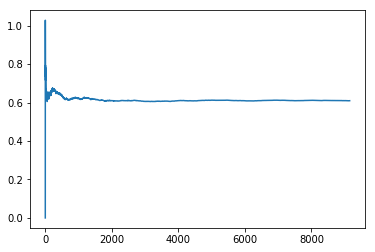

FINAL TRAINING STATS
Logloss:  0.6094693435735365
Precision:  0.6923909681410455
Recall:  0.7284412626098276
Accuracy:  0.6716205879138892
F1 Score:  0.7099587694259436


In [11]:
%matplotlib inline

y_train = train_labels.tolist()
p_train = train_predictions[:,1].tolist()

train_ax = create_logloss_subplot(p_train, y_train)
logloss = compute_logloss(p_train, y_train)
(F1, precision, recall, accuracy) = compute_stats(p_train, y_train)

plt.show()
print('FINAL TRAINING STATS')
print('Logloss: ', logloss)
print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('F1 Score: ', F1)

#### Cross Validation Set LogLoss Evaluation

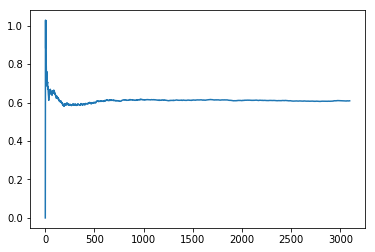

FINAL CROSS VAL. STATS
Logloss:  0.6088435922736284
Precision:  0.6910722720831365
Recall:  0.7088178294573644
Accuracy:  0.6668820678513732
F1 Score:  0.6998325759387706


In [12]:
%matplotlib inline

y_cval = cval_labels.tolist()
p_cval = cval_predictions[:,1].tolist()

cval_ax = create_logloss_subplot(p_cval, y_cval)
logloss = compute_logloss(p_cval, y_cval)
(F1, precision, recall, accuracy) = compute_stats(p_cval, y_cval)

plt.show()
print('FINAL CROSS VAL. STATS')
print('Logloss: ', logloss)
print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('F1 Score: ', F1)

#### Test Set LogLoss Evaluation

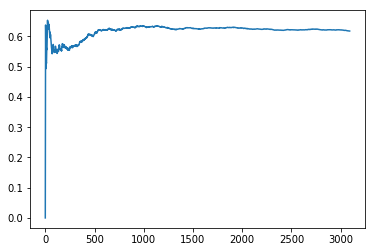

FINAL TEST STATS
Logloss:  0.6177739340473591
Precision:  0.6897977941176471
Recall:  0.7379547689282202
Accuracy:  0.6576139670223085
F1 Score:  0.7130641330166271


In [15]:
%matplotlib inline

y_test = test_labels.tolist()
p_test = test_predictions[:,1].tolist()

test_ax = create_logloss_subplot(p_test, y_test)
logloss = compute_logloss(p_test, y_test)
(F1, precision, recall, accuracy) = compute_stats(p_test, y_test)

plt.show()
print('FINAL TEST STATS')
print('Logloss: ', logloss)
print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('F1 Score: ', F1)